
NKE Attack
==============================




In [1]:
%matplotlib inline

In [17]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   

In [3]:
def attack(image, epsilon, data_grad, attack_type='fgsm'):
    opt = {'fgsm':1, 'nke':-1}

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + opt[attack_type] * epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [112]:
def testAttack( model, device, test_loader, epsilon,num_steps=1, attack_type='fgsm'):

    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []

    L_inf = []
    L_2 = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        total += 1

        for i in range(num_steps):
          loss = F.cross_entropy(output, target)        
          loss.backward()
          data_grad = data.grad.data
          perturbed_data = attack(data, epsilon, data_grad, attack_type)
          data.data = perturbed_data
          model.zero_grad()
          output = model(data)

          # compute L_inf distance
        a = np.abs((perturbed_data.detach().cpu()[0,0] - data.detach().cpu()[0,0]).flatten())  
        tmp = LA.norm(a, np.inf)
        tmp2 = LA.norm(a)
        L_inf.append(tmp)
        # L_0.append(tmp0)
        L_2.append(tmp2)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/total #float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, L_inf, L_2

In [71]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [63]:
def train(model, epoch, optimizer, train_loader, criterion=nn.CrossEntropyLoss()):
    total_loss = 0
    total_size = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item()
        total_size += data.size(0)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss / total_size))


def test(model, test_loader, criterion=nn.CrossEntropyLoss()):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [95]:
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



mean = {
'cifar10': (0.4914, 0.4822, 0.4465),
'cifar100': (0.5071, 0.4867, 0.4408),
}

std = {
'cifar10': (0.2023, 0.1994, 0.2010),
'cifar100': (0.2675, 0.2565, 0.2761),
}



transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=mean['cifar10'],
    #     std=std['cifar10']),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=100, shuffle=True, num_workers=2
)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, 100, shuffle=False, num_workers=2
)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Use exponential decay for fine-tuning optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975)


epochs = 30 
# Train
for epoch in range(1, epochs + 1):
    # Decay Learning Rate
    scheduler.step(epoch)
    train(model, epoch, optimizer, train_loader)
    test(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Train Epoch: 1 [0/50000 (0%)]	Average loss: 0.028455
Train Epoch: 1 [10000/50000 (20%)]	Average loss: 0.010494
Train Epoch: 1 [20000/50000 (40%)]	Average loss: 0.008536
Train Epoch: 1 [30000/50000 (60%)]	Average loss: 0.007617
Train Epoch: 1 [40000/50000 (80%)]	Average loss: 0.007054

Test set: Average loss: 0.0127, Accuracy: 6247/10000 (62%)

Train Epoch: 2 [0/50000 (0%)]	Average loss: 0.004534
Train Epoch: 2 [10000/50000 (20%)]	Average loss: 0.004332
Train Epoch: 2 [20000/50000 (40%)]	Average loss: 0.004461
Train Epoch: 2 [30000/50000 (60%)]	Average loss: 0.004597
Train Epoch: 2 [40000/50000 (80%)]	Average loss: 0.004673

Test set: Average loss: 0.0136, Accuracy: 6215/10000 (62%)

Train Epoch: 3 [0/50000 (0%)]	Average loss: 0.002951
Train Epoch: 3 [10000/50000 (20%)]	Average loss: 0.004486
Train Epoch: 3 [20000/50000 (40%)]	Average loss: 0.004432
Train Epoch: 3 [30000/50000 (60%)]	Average loss: 0.004484
Train Epoch: 3 [40000/50000 (80%)]	Average loss: 0.004617

Test set: Average loss

In [72]:
# !ls /gdrive/MyDrive/ClassificationImages/NewTypeExamples
pathh = '/gdrive/MyDrive/' 

In [73]:
torch.save(model.state_dict(), pathh+'NKE_cifar10.pth')

# Now perform adversarial attack

In [129]:
test_loader_new = torch.utils.data.DataLoader(
    test_set, 1, shuffle=False, num_workers=2
)

epsilons = [0, .01, .04, .07, .1, .4, .5, .6 , .9, .93, .96, .99, 1]

model.eval()

# Run test for each epsilon
accuracies = []
examples = []
infs = []
L2s = []


for eps in epsilons:
    acc, ex, m_L_inf, m_L_2 = testAttack(model, device, test_loader_new, eps, num_steps=5, attack_type='nke')
    accuracies.append(acc)
    examples.append(ex)
    infs.append(np.mean(m_L_inf)/256)
    L2s.append(np.mean(m_L_2)/256)
    # print(f'{eps}, {infs[-1]}, {L2s[-1]}: {acc}')



Epsilon: 0	Test Accuracy = 6122 / 6122 = 1.0
Epsilon: 0.01	Test Accuracy = 6120 / 6122 = 0.999673309376021
Epsilon: 0.04	Test Accuracy = 5818 / 6122 = 0.9503430251551781
Epsilon: 0.07	Test Accuracy = 5536 / 6122 = 0.9042796471741261
Epsilon: 0.1	Test Accuracy = 5232 / 6122 = 0.8546226723293041
Epsilon: 0.4	Test Accuracy = 4984 / 6122 = 0.8141130349558968
Epsilon: 0.5	Test Accuracy = 5032 / 6122 = 0.821953609931395
Epsilon: 0.6	Test Accuracy = 5128 / 6122 = 0.8376347598823913
Epsilon: 0.9	Test Accuracy = 5362 / 6122 = 0.8758575628879451
Epsilon: 0.93	Test Accuracy = 5352 / 6122 = 0.8742241097680497
Epsilon: 0.96	Test Accuracy = 5344 / 6122 = 0.8729173472721333
Epsilon: 0.99	Test Accuracy = 5256 / 6122 = 0.8585429598170532
Epsilon: 1	Test Accuracy = 5304 / 6122 = 0.8663835347925515


#plots

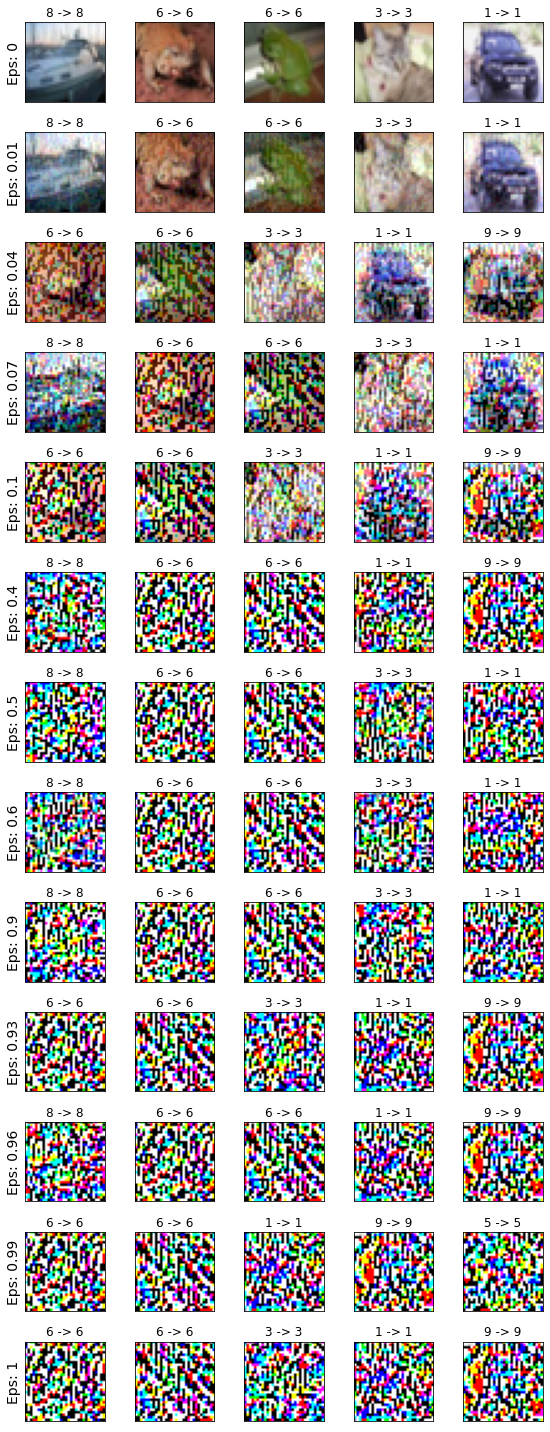

In [130]:
# Plot several examples of adversarial samples at each epsilon

# epsilons = epsilons[:7]

cnt = 0
plt.figure(figsize=(8,20))
# plt.figure(figsize=(8,10))
# for i in range(len(epsilons)):
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(np.transpose(ex, (1,2,0)))
plt.tight_layout()
plt.show()

In [91]:
a, b = next(iter(test_loader_new))

In [94]:
a.max()

tensor(2.6952)

In [132]:
def parse_data(res):
  indexes = [x.start() for x in re.finditer(' = ', res)]

  RES = []
  for i in indexes[1::2]:
    if res[i+3:i+6] in ['0.0', '1.0']:
      RES.append(float(res[i+2:i+7]))
    else:
      RES.append(float(res[i+2:i+8]))

  return RES


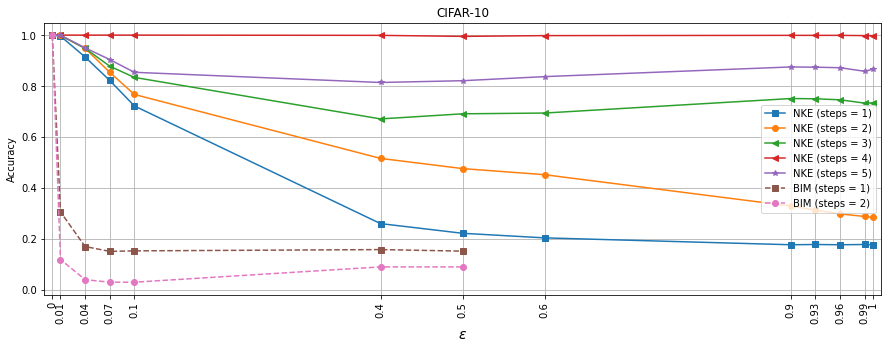

In [134]:
import re

fgsm_res1 = """Epsilon: 0	Test Accuracy = 6122 / 6122 = 1.0
Epsilon: 0.01	Test Accuracy = 1875 / 6122 = 0.30627245998039854
Epsilon: 0.04	Test Accuracy = 1044 / 6122 = 0.17053250571708592
Epsilon: 0.07	Test Accuracy = 928 / 6122 = 0.1515844495262986
Epsilon: 0.1	Test Accuracy = 941 / 6122 = 0.1537079385821627
Epsilon: 0.4	Test Accuracy = 968 / 6122 = 0.15811826200588044
Epsilon: 0.5	Test Accuracy = 933 / 6122 = 0.15240117608624631"""

fgsm_res2 = """Epsilon: 0	Test Accuracy = 6122 / 6122 = 1.0
Epsilon: 0.01	Test Accuracy = 729 / 6122 = 0.11907873244037896
Epsilon: 0.04	Test Accuracy = 280 / 6122 = 0.04573668735707285
Epsilon: 0.07	Test Accuracy = 242 / 6122 = 0.03952956550147011
Epsilon: 0.1	Test Accuracy = 235 / 6122 = 0.038386148317543285
Epsilon: 0.4	Test Accuracy = 551 / 6122 = 0.09000326690623979
Epsilon: 0.5	Test Accuracy = 566 / 6122 = 0.09245344658608298"""



net_res1 = """Epsilon: 0	Test Accuracy = 6122 / 6122 = 1.0
Epsilon: 0.01	Test Accuracy = 6102 / 6122 = 0.9967330937602091
Epsilon: 0.04	Test Accuracy = 5599 / 6122 = 0.9145704018294675
Epsilon: 0.07	Test Accuracy = 5037 / 6122 = 0.8227703364913427
Epsilon: 0.1	Test Accuracy = 4423 / 6122 = 0.7224763149297615
Epsilon: 0.4	Test Accuracy = 1594 / 6122 = 0.26037242731133614
Epsilon: 0.5	Test Accuracy = 1363 / 6122 = 0.22263966024175105
Epsilon: 0.6	Test Accuracy = 1251 / 6122 = 0.20434498529892192
Epsilon: 0.9	Test Accuracy = 1089 / 6122 = 0.17788304475661548
Epsilon: 0.93	Test Accuracy = 1090 / 6122 = 0.17804639006860504
Epsilon: 0.96	Test Accuracy = 1089 / 6122 = 0.17788304475661548
Epsilon: 0.99	Test Accuracy = 1090 / 6122 = 0.17804639006860504
Epsilon: 1	Test Accuracy = 1089 / 6122 = 0.17788304475661548"""


net_res2 = """Epsilon: 0	Test Accuracy = 6122 / 6122 = 1.0
Epsilon: 0.01	Test Accuracy = 6117 / 6122 = 0.9991832734400523
Epsilon: 0.04	Test Accuracy = 5804 / 6122 = 0.9480561907873244
Epsilon: 0.07	Test Accuracy = 5233 / 6122 = 0.8547860176412937
Epsilon: 0.1	Test Accuracy = 4699 / 6122 = 0.7675596210388762
Epsilon: 0.4	Test Accuracy = 3159 / 6122 = 0.5160078405749755
Epsilon: 0.5	Test Accuracy = 2919 / 6122 = 0.4768049656974845
Epsilon: 0.6	Test Accuracy = 2771 / 6122 = 0.4526298595230317
Epsilon: 0.9	Test Accuracy = 2020 / 6122 = 0.32995753021888274
Epsilon: 0.93	Test Accuracy = 1921 / 6122 = 0.31378634433191765
Epsilon: 0.96	Test Accuracy = 1829 / 6122 = 0.2987585756288795
Epsilon: 0.99	Test Accuracy = 1766 / 6122 = 0.28846782097353807
Epsilon: 1	Test Accuracy = 1740 / 6122 = 0.2842208428618099"""


net_res3 = """Epsilon: 0	Test Accuracy = 6122 / 6122 = 1.0
Epsilon: 0.01	Test Accuracy = 6118 / 6122 = 0.9993466187520418
Epsilon: 0.04	Test Accuracy = 5808 / 6122 = 0.9487095720352826
Epsilon: 0.07	Test Accuracy = 5378 / 6122 = 0.8784710878797779
Epsilon: 0.1	Test Accuracy = 5111 / 6122 = 0.8348578895785691
Epsilon: 0.4	Test Accuracy = 4112 / 6122 = 0.6716759229010127
Epsilon: 0.5	Test Accuracy = 4234 / 6122 = 0.6916040509637373
Epsilon: 0.6	Test Accuracy = 4251 / 6122 = 0.6943809212675596
Epsilon: 0.9	Test Accuracy = 4602 / 6122 = 0.7517151257758903
Epsilon: 0.93	Test Accuracy = 4593 / 6122 = 0.7502450179679844
Epsilon: 0.96	Test Accuracy = 4571 / 6122 = 0.7466514211042143
Epsilon: 0.99	Test Accuracy = 4490 / 6122 = 0.7334204508330611
Epsilon: 1	Test Accuracy = 4494 / 6122 = 0.7340738320810193"""


net_res4 = """Epsilon: 0	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.01	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.04	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.07	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.1	Test Accuracy = 9585 / 9585 = 1.0
Epsilon: 0.4	Test Accuracy = 9583 / 9585 = 0.9997913406364111
Epsilon: 0.5	Test Accuracy = 9544 / 9585 = 0.9957224830464267
Epsilon: 0.6	Test Accuracy = 9568 / 9585 = 0.998226395409494
Epsilon: 0.9	Test Accuracy = 9581 / 9585 = 0.9995826812728221
Epsilon: 0.93	Test Accuracy = 9579 / 9585 = 0.9993740219092332
Epsilon: 0.96	Test Accuracy = 9579 / 9585 = 0.9993740219092332
Epsilon: 0.99	Test Accuracy = 9575 / 9585 = 0.9989567031820553
Epsilon: 1	Test Accuracy = 9574 / 9585 = 0.9988523735002608"""

# step 5
net_res5 = """Epsilon: 0	Test Accuracy = 6122 / 6122 = 1.0
Epsilon: 0.01	Test Accuracy = 6120 / 6122 = 0.999673309376021
Epsilon: 0.04	Test Accuracy = 5818 / 6122 = 0.9503430251551781
Epsilon: 0.07	Test Accuracy = 5536 / 6122 = 0.9042796471741261
Epsilon: 0.1	Test Accuracy = 5232 / 6122 = 0.8546226723293041
Epsilon: 0.4	Test Accuracy = 4984 / 6122 = 0.8141130349558968
Epsilon: 0.5	Test Accuracy = 5032 / 6122 = 0.821953609931395
Epsilon: 0.6	Test Accuracy = 5128 / 6122 = 0.8376347598823913
Epsilon: 0.9	Test Accuracy = 5362 / 6122 = 0.8758575628879451
Epsilon: 0.93	Test Accuracy = 5352 / 6122 = 0.8742241097680497
Epsilon: 0.96	Test Accuracy = 5344 / 6122 = 0.8729173472721333
Epsilon: 0.99	Test Accuracy = 5256 / 6122 = 0.8585429598170532
Epsilon: 1	Test Accuracy = 5304 / 6122 = 0.8663835347925515"""





epsilons = [0, .01, .04, .07, .1, .4, .5, .6, .9, .93, .96, .99, 1]
plt.figure(figsize=(15,5))
plt.plot(epsilons, parse_data(net_res1), "s-")
plt.plot(epsilons, parse_data(net_res2), "o-")
plt.plot(epsilons, parse_data(net_res3), "<-")
plt.plot(epsilons, parse_data(net_res4), "<-")
plt.plot(epsilons, parse_data(net_res5), "*-")
plt.plot(epsilons[:7], parse_data(fgsm_res1), "s--")
plt.plot(epsilons[:7], parse_data(fgsm_res2), "o--")

# plt.plot(np.log10(infs),GAUSS_res, 's-')
# plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(epsilons, [str(e) for e in epsilons], rotation=90)
plt.title("CIFAR-10")
plt.xlabel("$\epsilon$", fontsize=14)
plt.ylabel("Accuracy")
plt.xlim(-0.01,1.01)
plt.grid(True)
plt.legend(['NKE (steps = 1)', 'NKE (steps = 2)', 'NKE (steps = 3)', 'NKE (steps = 4)', 'NKE (steps = 5)', 'BIM (steps = 1)', 'BIM (steps = 2)'])
plt.show()

# np.linspace(0,77,13).tolist()+[100,200,500,1000,2000]